In [1]:
import logging

In [2]:
logging.info("testing")

In [ ]:
def sample_posterior(model, views_vol, config, device): 

    """
    Samples from the posterior distribution of Hydranet.

    Args:
    - model: HydraNet
    - views_vol (torch.Tensor): Input views data.
    - config: Configuration file
    - device: Device for computations.

    Returns:
    - tuple: (posterior_magnitudes, posterior_probabilities, out_of_sample_data)
    """

    print(f'Drawing {config.test_samples} posterior samples...')

    # perhaps not on GPU? 
    test_tensor = get_test_tensor(views_vol, config, device) # better cal thiis evel tensor
    out_of_sample_vol = test_tensor[:,-config.time_steps:,:,:,:].cpu().numpy() # From the test tensor get the out-of-sample time_steps. 

    posterior_list = []
    posterior_list_class = []

    for i in range(config.test_samples): # number of posterior samples to draw - just set config.test_samples, no? 
        
        pred_np_list, pred_class_np_list = test(model, test_tensor, config.time_steps, config, device) # Returns two lists of numpy arrays (shape 3/180/180). One list of the predicted magnitudes and one list of the predicted probabilities.
        posterior_list.append(pred_np_list)
        posterior_list_class.append(pred_class_np_list)

        #if i % 10 == 0: # print steps 10
        print(f'Posterior sample: {i}/{config.test_samples}', end = '\r')

    return posterior_list, posterior_list_class, out_of_sample_vol

In [ ]:
    # Dump 1
    if config.sweep == False:
        dump_location = '/home/projects/ku_00017/data/generated/conflictNet/'
        posterior_dict = {'posterior_list' : posterior_list, 'posterior_list_class': posterior_list_class, 'out_of_sample_vol' : out_of_sample_vol}
        with open(f'{dump_location}posterior_dict_{config.time_steps}_{config.run_type}.pkl', 'wb') as file:
            pickle.dump(posterior_dict, file)

        print("Posterior pickle dumped!")

    else:
        print('Running sweep. no posterior pickle dumped')

In [13]:
tree_d_tensor01 = torch.tensor([[[1, 2, 3]], [[4, 5, 6]]])
tree_d_tensor02 = torch.tensor([[[7, 8, 9]], [[10, 11, 12]]])
tree_d_tensor03 = torch.tensor([[[13, 14, 15]], [[16, 17, 18]]])

tree_d_tensor = torch.cat((tree_d_tensor01, tree_d_tensor02, tree_d_tensor03), dim=1)

print(tree_d_tensor.shape[1])

3


In [8]:
two_d_tensor01 = torch.tensor([[1, 2, 3], [4, 5, 6]])
two_d_tensor02 = torch.tensor([[7, 8, 9], [10, 11, 12]])
two_d_tensor03 = torch.tensor([[13, 14, 15], [16, 17, 18]])

print(torch.cat((two_d_tensor01, two_d_tensor02, two_d_tensor03), dim=1).shape)

torch.Size([2, 9])


In [5]:
hidden_channels = 32


hidden_channels_split = int(hidden_channels/8)

hidden_channels_split * 4

16

In [1]:
import sys
import numpy as np
import torch
from torchvision import transforms
from torchvision.ops import sigmoid_focal_loss


import torch.nn as nn
import torch.nn.functional as F


from torch.autograd import Variable

# https://d2l.ai/chapter_recurrent-modern/gru.html

import matplotlib.pyplot as plt


sys.path.insert(0, "/home/simon/Documents/scripts/conflictNet/src/utils")
from warmup_decay_lr_scheduler import WarmupDecayLearningRateScheduler

In [33]:
torch.zeros((1, 32, 32, 32), dtype=torch.float32).shape

torch.Size([1, 32, 32, 32])

In [48]:
h = torch.zeros((1, 32, 32, 32), dtype=torch.float32)

h[:, :4, :, :] = 1
h[:, 4:8, :, :] = 2
h[:, 8:12, :, :] = 3
h[:, 12:16, :, :] = 4
h[:, 16:20, :, :] = 5
h[:, 20:24, :, :] = 6  
h[:, 24:28, :, :] = 7 
h[:, 28:32, :, :] = 8


In [52]:
split_8_ways = int(h.shape[1] / 8) 

hs1, hs2, hs3, hs4, hl1, hl2, hl3, hl4 = torch.split(h, split_8_ways, dim=1) 
new_h = torch.cat([hs1, hs2, hs3, hs4, hl1, hl2, hl3, hl4], dim=1)





print(new_h[:, :4, :, :].mean())
print(new_h[:, 4:8, :, :].mean())
print(new_h[:, 8:12, :, :].mean())
print(new_h[:, 12:16, :, :].mean())
print(new_h[:, 16:20, :, :].mean())
print(new_h[:, 20:24, :, :].mean())
print(new_h[:, 24:28, :, :].mean())
print(new_h[:, 28:32, :, :].mean())

tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)
tensor(5.)
tensor(6.)
tensor(7.)
tensor(8.)


In [44]:
hs4

tensor([[[[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.]],

         [[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.]],

         [[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.]],

         [[4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          

In [3]:
h = torch.zeros((1, 32, 32, 32), dtype=torch.float32)

h[:, :8, :, :] += 1  
h[:, 8:16, :, :] += 2 
h[:, 16:24, :, :] += 3
h[:, 24:, :, :] += 4

h_frozen = h.clone()
h_new = h.clone() * -1

In [4]:
split_four_ways = int(h_frozen.shape[1] / 4) 

hs_1_frozen, hs_2_frozen, hl_1_frozen, hl_2_frozen = torch.split(h_frozen, split_four_ways, dim=1)
hs_1_new, hs_2_new, hl_1_new, hl_2_new = torch.split(h_new, split_four_ways, dim=1) 

pairs = [(hs_1_frozen, hs_1_new), (hs_2_frozen, hs_2_new), (hl_1_frozen, hl_1_new), (hl_2_frozen, hl_2_new)]

h_mix = torch.cat([pair[0] if torch.rand(1) < 0.5 else pair[1] for pair in pairs], dim=1)



# ----------------------------


print(h_mix[:, :8, :, :].mean())
print(h_mix[:, 8:16, :, :].mean())
print(h_mix[:, 16:24, :, :].mean())
print(h_mix[:, 24:, :, :].mean())

tensor(-1.)
tensor(2.)
tensor(3.)
tensor(-4.)


In [5]:
print(h_mix[:, :8, :, :].mean())
print(h_mix[:, 8:16, :, :].mean())
print(h_mix[:, 16:24, :, :].mean())
print(h_mix[:, 24:, :, :].mean())

tensor(-1.)
tensor(2.)
tensor(3.)
tensor(-4.)


In [6]:
h_mix[:, 24:, :, :]

tensor([[[[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          ...,
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.]],

         [[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          ...,
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.]],

         [[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          ...,
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -4.,  ..., -4., -4., -4.]],

         ...,

         [[-4., -4., -4.,  ..., -4., -4., -4.],
          [-4., -4., -

In [91]:
selected_tensors = torch.cat(selected_tensors, dim=1)

In [92]:
selected_tensors.shape

torch.Size([1, 32, 32, 32])

In [66]:
split_hs_hl = int(h.shape[1] / 4)  # Half of the second dimension, which is channels

# Split the tensor along dimension 1 into 4 parts
hs_1, hs_2, hl_1, hl_2 = torch.split(h, split_hs_hl, dim=1)

# The result will be a tuple of four tensors
# hs_1, hs_2, hl_1, hl_2 = split_tensors_hs_hl

In [67]:
print(hs_1.shape)
print(hs_2.shape)
print(hl_1.shape)
print(hl_2.shape)

torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])


In [68]:
print(hs_1.mean())
print(hs_2.mean())
print(hl_1.mean())
print(hl_2.mean())

tensor(1.)
tensor(2.)
tensor(3.)
tensor(4.)


In [49]:
split_hs_hl = int(h.shape[1]/2) # half of the second dimension wich is channels

# Split the tensor along dimension 1
split_tensors_hs_hl = torch.split(h, split_hs_hl, dim=1)

# The result will be a tuple of two tensors
hs, hl = split_tensors_hs_hl

# Second split to get the two tensors that make up hs and hl
split_1_2 = int(split_hs_hl/2) # half of the second dimension wich is channels

split_tensors_hs1_hs2 = torch.split(hs, split_1_2, dim=1)

split_tensors_hl1_hl2 = torch.split(hl, split_1_2, dim=1)

hs_1, hs_2 = split_tensors_hs1_hs2
hl_1, hl_2 = split_tensors_hl1_hl2





In [ ]:
# Assuming you have h_a and h_b tensors

# Create lists of tensors from h_a and h_b
tensors_a = [hs_1a, hs_2a, hl_1a, hl_2a]
tensors_b = [hs_1b, hs_2b, hl_1b, hl_2b]

# Shuffle the order of selection
random.shuffle(tensors_a)
random.shuffle(tensors_b)

# Combine tensors from a and b
result_tensors = [tensors_a.pop() if random.choice([True, False]) else tensors_b.pop() for _ in range(4)]


In [50]:
print(hs_1.shape)
print(hs_2.shape)
print(hl_1.shape)
print(hl_2.shape)

torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])
torch.Size([1, 8, 32, 32])


In [ ]:
split = int(h_tt.shape[1]/2) # split h_tt into hs_tt and hl_tt and save hl_tt as the forzen cell state/long term memory. Call it hl_frozen. Half of the second dimension which is channels.
_, hl_frozen = torch.split(h_tt, split, dim=1)
t1_pred, t1_pred_class, h_tt = model(t0, h_tt) 
hs, _ = torch.split(h_tt, split, dim=1) # Again split the h_tt into hs_tt and hl_tt. But discard the hl_tt
h_tt = torch.cat((hs, hl_frozen), dim=1) # Concatenate the frozen cell state/long term memory (hl_frozen) with the new hidden state/short term memory. this is the new h_tt


In [41]:
for i in range(10):

    print(['j','a','e'][np.random.choice(3)])

j
j
j
e
a
e
j
e
e
e


In [1]:
def terning(max, antal, exprmnt):

    """
    Max er den højeste værdi terningen kan vise, dvs. ternings antal sider.
    Antal er antallet af terninger der kastes.
    Exprmnt er antallet af eksperimenter der udføres.
    """

    result = np.random.randint(1, max+1, (antal, exprmnt))

    return result

In [12]:
terning?

Signature: terning(max, antal, exprmnt)
Docstring:
Max er den højeste værdi terningen kan vise, dvs. ternings antal sider.
Antal er antallet af terninger der kastes.
exprmnt er antallet af eksperimenter der udføres.
File:      /tmp/ipykernel_51386/728988540.py
Type:      function


In [13]:
to_d_6_100 =  terning(6, 2, 100)
print(to_d_6_100)

[[3 2 2 5 4 3 3 4 4 3 2 2 4 5 4 3 3 4 5 4 1 5 5 2 4 5 3 3 3 4 2 4 4 5 2 3
  5 1 3 1 1 5 1 1 1 4 4 3 4 5 2 5 4 2 1 1 4 3 4 3 4 1 2 4 3 4 1 5 4 5 1 2
  2 4 3 1 2 4 4 5 2 2 5 3 4 1 1 2 4 4 3 2 4 3 4 5 5 4 1 4]
 [2 5 4 3 3 5 1 1 5 2 2 5 4 5 3 4 5 2 4 1 3 4 3 2 3 5 5 1 1 2 4 1 5 5 3 4
  1 3 3 2 2 2 3 4 1 2 1 3 5 3 4 1 1 4 5 1 3 5 1 1 5 5 3 5 2 3 2 1 3 2 5 1
  5 2 4 2 4 2 2 4 5 2 1 2 1 4 5 4 2 5 4 1 4 5 5 1 5 4 2 2]]


In [14]:
dmg = to_d_6_100.sum(0)
dmg

array([ 5,  7,  6,  8,  7,  8,  4,  5,  9,  5,  4,  7,  8, 10,  7,  7,  8,
        6,  9,  5,  4,  9,  8,  4,  7, 10,  8,  4,  4,  6,  6,  5,  9, 10,
        5,  7,  6,  4,  6,  3,  3,  7,  4,  5,  2,  6,  5,  6,  9,  8,  6,
        6,  5,  6,  6,  2,  7,  8,  5,  4,  9,  6,  5,  9,  5,  7,  3,  6,
        7,  7,  6,  3,  7,  6,  7,  3,  6,  6,  6,  9,  7,  4,  6,  5,  5,
        5,  6,  6,  6,  9,  7,  3,  8,  8,  9,  6, 10,  8,  3,  6])

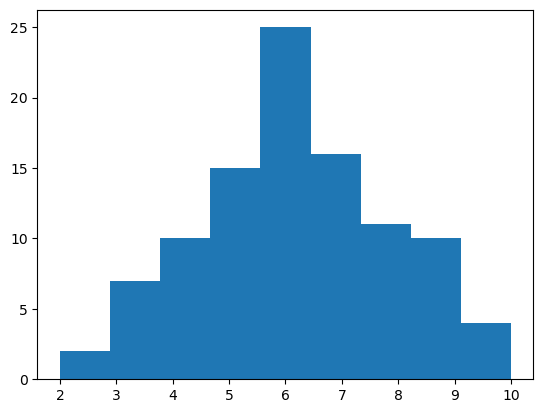

In [15]:
plt.hist(dmg, bins=9)
plt.show()

In [53]:
# full_vol = torch.zeros((300, 256, 256, 4), dtype=torch.float32) #  [N, C, D, H, W]

full_vol = torch.randn((300, 256, 256, 4), dtype=torch.float32)**2 #  [N, C, D, H, W]


full_vol[:, :, :, 0] += 99  
full_vol[:, :, :, 1] += 1 
full_vol[:, :, :, 2] += 2
full_vol[:, :, :, 3] += 3

full_vol = torch.log(full_vol+1)

In [54]:
full_vol

tensor([[[[4.6071, 1.9131, 2.0007, 1.3871],
          [4.6168, 0.8975, 1.2306, 1.4198],
          [4.6066, 0.9201, 1.2958, 1.4596],
          ...,
          [4.6072, 0.9943, 1.0989, 1.3930],
          [4.6068, 1.0841, 1.2980, 1.4747],
          [4.6066, 0.9120, 1.1755, 1.5574]],

         [[4.6068, 1.8559, 1.1686, 1.4734],
          [4.6082, 1.0379, 1.5292, 1.5191],
          [4.6067, 0.7474, 1.1406, 1.4072],
          ...,
          [4.6149, 1.2681, 1.1181, 1.4900],
          [4.6069, 0.8128, 1.2314, 1.5005],
          [4.6063, 1.0456, 1.1055, 1.3885]],

         [[4.6300, 0.9509, 1.1051, 1.5466],
          [4.6055, 0.7621, 1.2789, 1.6862],
          [4.6052, 1.9078, 1.0990, 1.4118],
          ...,
          [4.6409, 1.1312, 1.4496, 1.3982],
          [4.6087, 0.7045, 1.1326, 1.7147],
          [4.6086, 1.1747, 2.1570, 1.5328]],

         ...,

         [[4.6142, 0.6940, 1.1042, 1.6339],
          [4.6281, 0.6940, 1.3758, 1.4216],
          [4.6052, 1.1891, 1.2322, 1.3966],
          

In [55]:
config = {
    'first_feature_idx': 1,
    'input_channels': 3}


a = 0
b = 1

In [58]:
def norm_features(full_vol ,config, un_log = True, a = 0, b = 1) -> np.ndarray:

    """
    Normalize the features of the volume. One by one to the range [a, b]. 
    """
    

    first_feature_idx = config['first_feature_idx'] #config.first_feature_idx
    last_feature_idx = first_feature_idx + config['input_channels'] - 1 #config.first_feature_idx + config.input_channels - 1


    for i in range(first_feature_idx, last_feature_idx + 1):

        feature = full_vol[:, :, :, i] 

        # if config.un_log:
        #     feature = torch.exp(feature) - 1

        feature_max = feature.max() # could make sure that we are not using information from the future.... But this is not a big deal... 
        feature_min = 0 #full_vol[:, :, :, i].min()

        feature_norm = (b-a)*(feature - feature_min)/(feature_max-feature_min)+a

        full_vol[:,:,:,i] = feature_norm

    return full_vol

In [ ]:
def norm_channels(tensor, config, un_log = True, a = 0, b = 1) -> torch.Tensor: # not reall a tensor now but an array...

    """
    Normalizes the feature channels for a tensor  to the range [a, b].
    Defualt is [-1, 1] to match the batch norm layers.
    The input tensor is expected to have the shape [N, C, D, H, W]
    Where N is the batch size, C is the number of timesteps, D is the features, H is the height and W is the width.   
    """

    # if un_log:
    #     tensor = torch.exp(tensor)

    first_feature_idx = config['first_feature_idx'] #config.first_feature_idx
    last_feature_idx = first_feature_idx + config['input_channels'] - 1 #config.first_feature_idx + config.input_channels - 1

    min_list = []
    max_list = []

    for i in range(first_feature_idx, last_feature_idx + 1):
        #min_list.append(np.min(tensor[ :, :, :, i]))
        max_list.append(np.max(tensor[ :, :, :, i]))

    # norm_tensor = (b-a)*(tensor - tensor.min())/(tensor.max()-tensor.min())+a

    norm_tensor = (b-a)*(tensor - 0)/(8-0)+a # 8 just hardcoded until later....

In [11]:
def norm_channels(tensor, config, pre_logged = True, a = -1, b = 1) -> torch.Tensor:

    """
    Normalizes the feature channels for a tensor  to the range [a, b].
    Defualt is [-1, 1] to match the batch norm layers.
    The input tensor is expected to have the shape [N, C, D, H, W]
    Where N is the batch size, C is the number of timesteps, D is the features, H is the height and W is the width.   
    """

    if pre_logged:
        tensor = torch.exp(tensor)

    first_feature_idx = config['first_feature_idx'] #config.first_feature_idx
    last_feature_idx = config['first_feature_idx'] + config['input_channels'] - 1 #config.first_feature_idx + config.input_channels - 1

    min_list = []
    max_list = []

    for i in range(first_feature_idx, last_feature_idx + 1):
        min_list.append(torch.min(tensor[:, :, i, :, :]))
        max_list.append(torch.max(tensor[:, :, i, :, :]))

    norm_tensor = (b-a)*(tensor - tensor.min())/(tensor.max()-tensor.min())+a
    
    return norm_tensor


In [12]:
logged_norm = norm_channels(log_full_vol, config, pre_logged = True, a = 0, b = 1)

In [13]:
print(logged_norm.max())
print(logged_norm.min())

tensor(1.)
tensor(0.)


In [5]:
norm_sub_vol = norm_channels(sub_vol, config, pre_logged = True)

print(norm_sub_vol.max())
print(norm_sub_vol.min())

tensor(1.)
tensor(-1.)


In [ ]:
def norm(x, a = 0, b = 1):

    """Return a normalized x in range [a:b]. Default is [0:1]"""
    x_norm = (b-a)*(x - x.min())/(x.max()-x.min())+a
    return(x_norm)

In [ ]:
config.first_feature_idx

In [ ]:
# Assuming you have a tensor with dimensions H x W x C
tensor = torch.rand(180, 180, 3)  # Replace this with your actual tensor

# Calculate maximum and minimum values for each channel (C dimension)
max_values, _ = torch.max(tensor, dim=(0, 1))  # Max values for each channel
min_values, _ = torch.min(tensor, dim=(0, 1))  # Min values for each channel


In [ ]:
max_values.shape

In [ ]:
batch_size = 3
seq_len = 300
window_size = 180
 

Q  =  torch.randn(batch_size, seq_len, window_size, window_size)
Q.shape

In [ ]:
Q = torch.tensor([[[1,1,1],[1,1,1],[1,1,1]],[[2,2,2],[2,2,2],[2,2,2]],[[3,3,3],[3,3,3],[3,3,3]]])

In [ ]:
torch.max(Q, dim=2)

In [ ]:
torhc.max(Q, dim)

In [ ]:
min_max_values

In [ ]:
WarmupDecayLearningRateScheduler?

In [ ]:
lr_list = []
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.001
optimizer = torch.optim.Adam(model,lr = LR)

samples = 10000


# ---------------------------

scheduler = WarmupDecayLearningRateScheduler(optimizer, 32*32*3, 100)
for epoch in range(samples):
    data_size = 40
    for i in range(data_size):
        optimizer.step()
    scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

plt.plot(range(samples),lr_list,color = 'r')
plt.hlines(y=0,xmin=0, xmax=samples,  colors = "c",linestyles = "dashed")
plt.show()

In [ ]:
lr_list = []
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.001
optimizer = torch.optim.Adam(model,lr = LR)

samples = 300


# ---------------------------

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = samples*0.04, eta_min = 0.00005)
for epoch in range(samples):
    data_size = 40
    for i in range(data_size):
        optimizer.step()
    scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

plt.plot(range(samples),lr_list,color = 'r')
plt.hlines(y=0,xmin=0, xmax=samples,  colors = "c",linestyles = "dashed")
plt.show()

In [ ]:
batch_size = 3
seq_len = 300
d_model = 1000
 

Q  =  torch.randn(batch_size, seq_len, d_model)
print(Q.shape)



n_head = 2

Q = Q.view(batch_size, seq_len, n_head, -1).permute(0, 2, 1, 3)
print(Q.shape)



In [ ]:
np.exp(np.log(9))

In [ ]:

torch.exp(torch.log(torch.tensor(9.0)+1))-1

In [ ]:
def small_test(x,y) -> torch.Tensor:
    return x+y

In [ ]:
z = small_test(1, 2)

type(z)

In [ ]:
small_test?

In [ ]:
# Create a tensor of size [1, 10, 32, 32]
hc = torch.randn(1, 10, 32, 32)

split = int(hc.shape[1]/2) # half of the second dimension wich is channels

# Split the tensor along dimension 1
split_tensors = torch.split(hc, split, dim=1)

# The result will be a tuple of two tensors
h0, c0 = split_tensors

# Print the sizes of the split tensors
print(h.size())  # torch.Size([1, 5, 32, 32])
print(c.size())  # torch.Size([1, 5, 32, 32])

In [ ]:
c0 = c0 * 0 

In [ ]:
hc = torch.cat([h0, c0], 1) 

In [ ]:
# Split the tensor along dimension 1
split_tensors = torch.split(hc, split, dim=1)

# The result will be a tuple of two tensors
h1, c1 = split_tensors

# Print the sizes of the split tensors
print(h1.size())  # torch.Size([1, 5, 32, 32])
print(c1.size())  # torch.Size([1, 5, 32, 32])

In [ ]:
h0 == h1

In [ ]:
h.shape

In [ ]:
tensor2.shape

In [ ]:
hc = torch.zeros((1,10,32,32), dtype= torch.float64)



In [ ]:
input_tensor.shape

In [ ]:
hc.shape

In [ ]:
channels = hc.shape[1]
split = int(channels/2)

# Split the tensor along dimension 1
split_tensors = torch.split(hc, split, dim=1)

c.shape, h.shape

In [ ]:
channels

In [ ]:
kernel_size = 3
padding = kernel_size // 2

In [ ]:
padding

In [ ]:
base = 10
dim = 2

cube = base**dim

print(np.sqrt(cube)) # assuming dim is 2
print(np.log10(cube)) # assuming base is 10

In [ ]:
lr_list = []
model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.001
optimizer = torch.optim.Adam(model,lr = LR)

samples = 300


# ---------------------------

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = samples*0.04, eta_min = 0.00005)
for epoch in range(samples):
    data_size = 40
    for i in range(data_size):
        optimizer.step()
    scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

plt.plot(range(samples),lr_list,color = 'r')
plt.hlines(y=0,xmin=0, xmax=samples,  colors = "c",linestyles = "dashed")
plt.show()

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        padding = kernel_size // 2

        # Input gate
        self.Wxi = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Whi = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)
        self.Wxf = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Whf = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)
        self.Wxc = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Whc = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)
        self.Wxo = nn.Conv2d(input_channels, hidden_channels, kernel_size, padding=padding)
        self.Who = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding)

    def forward(self, x, hidden):
        h, c = hidden

        # Input gate
        i_t = torch.sigmoid(self.Wxi(x) + self.Whi(h))
        # Forget gate
        f_t = torch.sigmoid(self.Wxf(x) + self.Whf(h))
        # Cell state
        c_tilde = torch.tanh(self.Wxc(x) + self.Whc(h))
        c = f_t * c + i_t * c_tilde
        # Output gate
        o_t = torch.sigmoid(self.Wxo(x) + self.Who(h))
        h = o_t * torch.tanh(c)

        return h, c

# Example usage
input_channels = 3
hidden_channels = 10
kernel_size = 3
cell = ConvLSTMCell(input_channels, hidden_channels, kernel_size)
x = torch.randn(1, input_channels, 32, 32)
hidden_state = (torch.randn(1, hidden_channels, 32, 32), torch.randn(1, hidden_channels, 32, 32))

output, new_hidden_state = cell(x, hidden_state)


In [ ]:
output.shape

In [ ]:
#input = np.random.randint(1,21,[5,5,5])
#input = torch.from_numpy(X)

B = 1
C = 3
H = 5
W = 5 

input = torch.randn(1,3,3,5,5)
m = nn.Linear(5, 5, bias=False)
output = m(input)
print(output.size())



In [ ]:
input

In [ ]:
output

In [ ]:
input

In [ ]:
m = nn.Linear((3,5), (3,5))
#input = torch.randn(128, 20)
output = m(input)
print(output.size())

In [ ]:
X = np.random.randint(1,21,[5,5,5])
X_tensor = torch.tensor(X)

In [ ]:
X_tensor = torch.tensor(X)

In [ ]:
X_tensor

In [ ]:
criterion_reg = nn.MSELoss()
criterion_class = nn.BCELoss()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(
            self,
            weight=None,
            gamma=2.0,
            reduction='mean'
    ):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = torch.sigmoid(input_tensor)
        prob = torch.exp(log_prob)
        
        term = ((1.0 - prob) ** self.gamma) * log_prob
        return F.nll_loss(term, target_tensor)
        
        #return F.nll_loss(term, target_tensor, weight=self.weight, reduction=self.reduction)
        

In [ ]:
class FocalLoss01(nn.Module):

    def __init__(self, gamma=0, weight=None, size_average=True):
        super(FocalLoss01, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.contiguous().view(input.size(0), input.size(1), -1)
            input = input.transpose(1,2)
            input = input.contiguous().view(-1, input.size(2)).squeeze()
        if target.dim()==4:
            target = target.contiguous().view(target.size(0), target.size(1), -1)
            target = target.transpose(1,2)
            target = target.contiguous().view(-1, target.size(2)).squeeze()
        elif target.dim()==3:
            target = target.view(-1)
        else:
            target = target.view(-1, 1)

        # compute the negative likelyhood
        weight = Variable(self.weight)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss02(nn.Module):

    def __init__(self, gamma=0, weight=None, size_average=True):
        super(FocalLoss02, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        # if input.dim()>2:
        #     input = input.contiguous().view(input.size(0), input.size(1), -1)
        #     input = input.transpose(1,2)
        #     input = input.contiguous().view(-1, input.size(2)).squeeze()
        # if target.dim()==4:
        #     target = target.contiguous().view(target.size(0), target.size(1), -1)
        #     target = target.transpose(1,2)
        #     target = target.contiguous().view(-1, target.size(2)).squeeze()
        # elif target.dim()==3:
        #     target = target.view(-1)
        # else:
        #     target = target.view(-1, 1)

        input, target = input.unsqueeze(0), target.unsqueeze(0)

        # compute.unsqueeze(0)F.cross_entropy(input, target)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss03(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss03, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)

        # compute.unsqueeze(0)F.cross_entropy(input, target)
        p = 1/(1+np.exp(-input))
        loss = -( self.alpha*target + (1-self.alpha)*(1-target) ) * (( 1 - ( target*p + (1-target)*(1-p)) )**self.gamma) * ( target*np.log(p)+(1-target)*np.log(1-p) )

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss04(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss04, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):
        
        input, target = input.unsqueeze(0), target.unsqueeze(0)

        loss = -(target * np.log(input) + (1-target) * np.log(1-input)) #BCE

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss05(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss05, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        logpt = (target * np.log(input) + (1-target) * np.log(1-input))
        loss = -self.alpha * ((1-np.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
# BEST!!!

class FocalLoss05(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss05, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        logpt = (target * np.log(input) + (1-target) * np.log(1-input))
        loss = -self.alpha * ((1-np.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLossClass(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLossClass, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)

        logpt = (target * torch.log(input) + (1-target) * torch.log(1-input))
        loss = -self.alpha * ((1-torch.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
# #WORKS!
# class BalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(BalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)
#         input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)

#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))

#         #pos = ( (1-input)**self.gamma * torch.log(input))
#         #neg = ( (input)**self.gamma *  torch.log(1-input))

#         loss = -(pos * target + neg * (1-target))

#         # averaging (or not) loss
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
# class BalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(BalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)
        

#         #for logits
#         # pos = (-self.alpha * (1-F.sigmoid(input))**self.gamma * F.logsigmoid(input))
#         # neg = (-(1-self.alpha) * (-F.sigmoid(input))**self.gamma *  F.logsigmoid(1-input))
#         # loss = (pos * target + neg * (1-target))

#         # for probs
#         input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)
#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))
#         loss = (pos * target + neg * (1-target))

#         # averaging (or not) loss
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
# class stableBalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(stableBalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)

#         # fo   r probs
#         min_ind = torch.exp(torch.tensor(-100)) # almost 0
#         max_ind = torch.tensor(1.0)- torch.exp(torch.tensor(-10)) # almost 1
#         input = torch.clamp(input, min = min_ind, max = max_ind) # so we do not log(0)

#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))
#         loss = (pos * target + neg * (1-target))

#         # Seem pytorch have something like this..
#         if loss.mean() >= max_ind:
#             floor = 10
#         else:
#             floor = 1

#         loss =  loss * 2 * floor # *2 is just a constant to make it more like BCE

#         # averaging (or not) lossinput = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)
        
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
def shannon_entropy(p):
    return (p * np.log(1/p)).sum()

def cross_entropy(p, q):
    return -(p * np.log(q)).sum() # same as (p * np.log(1/q)).sum() 

In [ ]:
class BalancedFocalLossClass(nn.Module):

    def __init__(self, gamma=0, alpha=0.5, size_average=True):
        super(BalancedFocalLossClass, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        
        # Numerical stabilityt pytorhc trick.
        log_input = torch.clamp(torch.log(input), -100, 100)
        log_input_rev = torch.clamp(torch.log(1-input), -100, 100)

        # for probs
        pos = (-self.alpha * (1-input)**self.gamma * log_input)
        neg = (-(1-self.alpha) * (1-1-input)**self.gamma * log_input_rev)
        
        loss = (pos * target + neg * (1-target))

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_class = nn.BCELoss()

x1 = torch.rand([ 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
# criterion_focal01 = FocalLoss01(gamma=1)
# criterion_focal02 = FocalLoss02(gamma=1, size_average=False)
# criterion_focal03 = FocalLoss03(gamma=1, alpha = 1, size_average=True)

# criterion_focal04 = FocalLoss04(gamma=0)
# criterion_focal05 = FocalLoss05()

#criterion_focal06 = FocalLossClass()
criterion_focal07 = BalancedFocalLossClass(gamma=2, alpha=0.05)
# criterion_focal07 = stableBalancedFocalLossClass(gamma=0, alpha=0.5)


# print(criterion_focal01(x1.unsqueeze(0), x1_b.unsqueeze(0)))
# print(criterion_focal02(x1, x1_b))
# print(criterion_focal03(x1, x1_b))


# print(criterion_focal04(x1, x1_b))

# print(criterion_focal05(x1, x1_b))

#print(criterion_focal06(x1, x1_b))

print(criterion_focal07(x1, x1_b)) 


print(criterion_class(x1, x1_b))


In [ ]:
criterion_focal07 = BalancedFocalLossClass(gamma=0, alpha=0.5)

print(criterion_focal07(x1, x1_b)) 
print(criterion_class(x1, x1_b))

In [ ]:
x1 = torch.rand([ 3 ,100, 100]) 

x2 = torch.zeros([ 3 ,100, 100]) + torch.tensor(1.0) - torch.exp(torch.tensor(0))

x1_b = (x1 > 0.5)*1.0 


print(criterion_focal07(x2, x1_b)*2) 
print(criterion_class(x2, x1_b))

In [ ]:
x2

In [ ]:
x1 = torch.rand([ 3 ,100, 100]) 

x2 = torch.zeros([ 3 ,100, 100]) + torch.tensor(1.0) - torch.exp(torch.tensor(-12))

x1_b = (x1 > 0.5)*1.0 

if x2.mean() > torch.tensor(1.0) - torch.exp(torch.tensor(-15)):
    floor = 10
else:
    floor = 1

print(criterion_focal07(x2, x1_b) * floor) 
print(criterion_class(x2, x1_b))

In [ ]:
print(criterion_class)

In [ ]:
criterion_focal_class01 = BalancedFocalLossClass(gamma=0.0, alpha=0.75)
criterion_focal_class02 = BalancedFocalLossClass(gamma=2.0, alpha=0.25)
criterion_focal_class03 = BalancedFocalLossClass(gamma=5.0, alpha=0.25)

In [ ]:
print(f'focal, gamma = 0, alpha = 1 : \t {criterion_focal_class01(x1, x1_b)}')
print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_class02(x1, x1_b)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_class03(x1, x1_b)}')

In [ ]:
F.logsigmoid(torch.tensor(.00))

In [ ]:
# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32)

# candidates
ZT = torch.zeros([ 3 ,100, 100])
RT = torch.rand([ 3 ,100, 100]) 

# the loss must priorities 0T over ZT

In [ ]:
criterion = BalancedFocalLossClass(gamma=2, alpha=0.95)


print(criterion(ZT, IT)) 
print(criterion(RT, IT)) 

In [ ]:
class FocalLoss_reg(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss_reg, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        mse = (target - input)**2

        loss = self.alpha * ((1-np.exp(mse))**self.gamma) * mse # for gamma = 0 and alpha = 1 we get the mse

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_reg = nn.MSELoss()

x1 = torch.rand([ 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
criterion_focal_reg01 = FocalLoss_reg(gamma=0)
criterion_focal_reg02 = FocalLoss_reg(gamma=1)
criterion_focal_reg03 = FocalLoss_reg(gamma=2)

In [ ]:
# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32)

# candidates
ZT = torch.zeros([ 3 ,100, 100])
OT = torch.zeros([ 3 ,100, 100]) + 1

# the loss must priorities 0T over ZT

In [ ]:
print(f'MSE: \t\t\t\t {criterion_reg(ZT, IT)}')
print(f'focal, gamma = 0, alpha = 1 : \t {criterion_focal_reg01(ZT, IT)}')
print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_reg02(ZT, IT)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_reg03(ZT, IT)}')


print('\n')

print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_reg01(OT, IT)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_reg02(OT, IT)}')
print(f'focal, gamma = 3, alpha = 1 : \t {criterion_focal_reg03(OT, IT)}')



In [ ]:
def MSE(input, target):
    loss = (target - input)**2
    return loss.mean()

In [ ]:
def MSE(input, target):
    se = target - input
    lse = np.exp(se)  #torch.clamp(se, min = np.exp(-100)))
    mlse = lse.mean()

    return mlse

    # return - np.log(loss.mean())

In [ ]:
noise = torch.rand([ 3 ,100, 100]) * 10

# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32) * noise

# candidates
ZT = torch.zeros([ 3 ,100, 100])
OT = (torch.zeros([ 3 ,100, 100]) + 1 ) * noise

# the loss must priorities 0T over ZT

In [ ]:
print(MSE(ZT, IT))
print(MSE(OT, IT))

In [ ]:
OT.min()

In [ ]:
class FocalLoss_reg(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss_reg, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        #input = torch.clamp(input, min = np.exp(-100)) # could do this for no negatives???

        error = target - input
        exp_error = np.exp(error)  #torch.clamp(se, min = np.exp(-100)))
        loss = exp_error.mean()

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class ShrinkageLoss(nn.Module):

    def __init__(self, a=10, c=0.2, size_average=True):
        super(ShrinkageLoss, self).__init__()

        self.a = a
        self.c = c
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0) 

        l = torch.abs(target - input)     #F.l1_loss(input, target)

        loss = (l**2)/(1 + torch.exp(self.a*(self.c-l)))

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_focal_reg = ShrinkageLoss(a=10, c=0.2)

In [ ]:
criterion_focal_reg = ShrinkageLoss(a=1, c=12)

print(criterion_focal_reg(ZT, IT))
print(criterion_focal_reg(OT, IT))


In [ ]:
x1_b.dtype

In [ ]:
IT

In [ ]:
shannon_entropy(x1)

In [ ]:
cross_entropy(x1_b, x1)

In [ ]:
cross_entropy(x1_b, x1)

In [ ]:
F.cross_entropy( x1_b, x1)

In [ ]:
F.cross_entropy?

In [ ]:
-(x1_b * np.log(x1)).mean()

In [ ]:
(x1_b * (np.log(1/x1))).mean()

In [ ]:
print(criterion_focal02(x1, x1_b))
print(criterion_class(x1, x1_b))


In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [ ]:
t = 3

if t == 1 or t == 0:
    print('cool')

In [ ]:
cr.

In [ ]:
cr = RMSLELoss()
print(f'sgoairb: {cr}\n..................')

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
x1 = torch.rand([3,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
criterion_focal = FocalLoss2d()

In [ ]:
print(criterion_focal)

In [ ]:
criterion_focal(x1.unsqueeze(0), x1_b.unsqueeze(0))

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

sigmoid_focal_loss(x1, x1_b, reduction= 'mean')

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])#.type(torch.LongTensor)
x1_b = (x1 > 0.5)*1.0 

criterion_focal(x1.reshape(-1), x1_b.reshape(-1).type(torch.LongTensor))

In [ ]:
x1 = torch.randn([1, 3 ,100, 100]).float()

#x1 = torch.randn([1, 3 ,100, 100]).float()
x2 = torch.randn([1, 3 ,100, 100]).float()

x3 = torch.randn([1, 3 ,100, 100]).float()
x4 = torch.randn([1, 3 ,100, 100]).float()

In [ ]:
# x1_ = x1.reshape(-1)
# x2_ = x2.reshape(-1)

# mask = x1_ > 0

# x1_[mask].shape

# criterion_reg(x1_, x2_)


In [ ]:
type(losses_list) == list

In [ ]:
losses_list = []

for i in range(3):

    x1_ = x1[:,i,:,:].reshape(-1)
    x2_ = x2[:,i,:,:].reshape(-1)
    mask = (x3[:,i,:,:].reshape(-1) > 0.0001) | (x4[:,i,:,:].reshape(-1) > 0.0001)

    losses_list.append(criterion_reg(x1_[mask], x2_[mask]))


In [ ]:
losses_list

In [ ]:
for i in range(3):
    losses_list.append(criterion_class(t1_pred_class[:,i,:,:], t1_binary[:,i,:,:]))

In [ ]:
losses_list = []

for i in range(3):
    print(i)
    losses_list.append(torch.tensor(1.0))

for i in range(3):
    losses_list.append(torch.tensor(2.0))


In [ ]:
losses = torch.stack(losses_list)

In [ ]:
losses[:3].sum()

In [ ]:
losses[-3:].sum()


In [ ]:
for i in range(6):
    print(losses[i])

In [ ]:
hidden_channels = 32
D = 16 


X = torch.rand(1, 3, D, D)
H = torch.rand(1, hidden_channels, D, D)

In [ ]:
H+X

In [ ]:
c1 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c2 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

c3 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c4 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

c5 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c6 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

In [ ]:
Z = torch.sigmoid(c1(X) + c2(H))

R = torch.sigmoid(c3(X) + c4(H))

H_tilde = torch.tanh(c5(X) + c6(torch.mul(R,H)))

H = torch.mul(torch.mul(Z,H) + (1 - Z), H_tilde)

In [ ]:
H.shape

In [ ]:
vol = np.zeros([1,48,3,180,180])
tens  =torch.tensor(vol)

torch.stack((tens,tens)).shape

In [ ]:
vol = np.zeros([1,48,3,180,180])

In [ ]:
vol[:,:,0,:,:] = 1
vol[:,:,1,:,:] = 2
vol[:,:,2,:,:] = 3


In [ ]:
print(vol.shape)
print(vol[:,:,0,:,:].mean())
print(vol[:,:,1,:,:].mean())
print(vol[:,:,2,:,:].mean())

In [ ]:
N = vol.shape[0] # batch size. Always 1
C = vol.shape[1] # months
D = vol.shape[2] # features
H = vol.shape[3] # height
W = vol.shape[4] # width

vol2 = vol.reshape(N, C*D, H, W)
print(vol2.shape)

In [ ]:
# transformer = transforms.Compose([transforms.RandomRotation((0,360)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])
transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])

In [ ]:
#data augmentation (can be turned of for final experiments)        
vol2 = transformer(torch.tensor(vol2)) # rotations and flips # skip for now... '''''''''''''''''''''''''''''''''''''''''''''''''''''' bug only take 4 dims.. could just squezze the batrhc dom and then give it again afterwards?#train_tensor = train_tensor.reshape(N, C, D, H, W)

In [ ]:
vol3 = vol2.reshape(N,C,D,H,W)
print(vol3.shape)
print(vol3[:,:,0,:,:].mean())
print(vol3[:,:,1,:,:].mean())
print(vol3[:,:,2,:,:].mean())

In [ ]:
(vol3 == vol).all()